In [1]:
import cv2               as cv
import urllib
import numpy             as np
import pandas            as pd
import seaborn           as sns
import random
import os
import glob
import shutil
from imutils        import paths
import matplotlib.pyplot as plt
from sklearn.utils  import shuffle
from urllib.request import urlopen
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models              import Sequential
from tensorflow.keras.preprocessing       import image
from tensorflow.keras.utils               import to_categorical
from tensorflow.keras.callbacks           import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers              import Conv2D,Flatten,MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img

## 1-) Data Preparation

Data Preprocessing + Data Augmentation

In [7]:
folder_path = "Dataset\Dataset_nonsplit"

target_size = (240,240)

labels_brain = {"Brain Tumor":0,
                "Healthy"    :1}

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
#
#Folders
original_dataset_folder = "Dataset\Dataset_nonsplit"
base_folder = 'Dataset/Dataset_Split'
os.makedirs(base_folder, exist_ok=True)
#Create Folders
train_folder = os.path.join(base_folder, 'train')
os.makedirs(train_folder, exist_ok=True)
test_folder = os.path.join(base_folder, 'test')
os.makedirs(test_folder, exist_ok=True)
#Create Class folders
classes = os.listdir(original_dataset_folder)
for class_ in classes:
    os.makedirs(os.path.join(train_folder, class_), exist_ok=True)
    os.makedirs(os.path.join(test_folder, class_), exist_ok=True)
#Copy images
for class_ in classes:
    src_folder = os.path.join(original_dataset_folder, class_)
    all_filenames = os.listdir(src_folder)
    # 80% train - 20% test
    train_filenames, test_filenames = train_test_split(all_filenames, test_size=0.2, random_state=42)
    # Copy
    for filename in train_filenames:
        shutil.copy(os.path.join(src_folder, filename), os.path.join(train_folder, class_, filename))
    for filename in test_filenames:
        shutil.copy(os.path.join(src_folder, filename), os.path.join(test_folder, class_, filename))

In [8]:
#Data augmentation is only for train set.
train_datagen = ImageDataGenerator(rescale           =1.0/255, # Normalization
                                   zoom_range        =0.2,     # Random zoom
                                   width_shift_range =0.2,     # Random shift
                                   height_shift_range=0.2,     # Random shift
                                   validation_split  =0.125)   # 10% for validation split
#No augmentation for test set.
test_datagen  = ImageDataGenerator(rescale = 1.0/255)

In [9]:
# Generators for sets

train_generator = train_datagen.flow_from_directory(directory='Dataset/Dataset_Split/train',         #Train images
                                                    target_size=target_size,                              #size of images
                                                    batch_size=32,                                        #Mini-batch size
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)                                         #Shuffle for every epoch

val_generator   = train_datagen.flow_from_directory(directory='Dataset/Dataset_Split/train',         #Validation images
                                                   target_size=target_size,                               #size of images
                                                   batch_size=32,                                         #Mini-batch size
                                                   class_mode='categorical', 
                                                   subset='validation')

test_generator  = test_datagen.flow_from_directory(directory='Dataset/Dataset_Split/test',           #Test images
                                                   target_size=target_size,                               #size of images
                                                   batch_size=32,                                         #Mini-batch size
                                                   class_mode='categorical',
                                                   shuffle=False)                                         #During the final evaluation, 
                                                                                                          # analysis must be performed 
                                                                                                          # in a fixed order.

Found 3220 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 921 images belonging to 2 classes.


## 2-) Data Visualization

------------Train Set------------


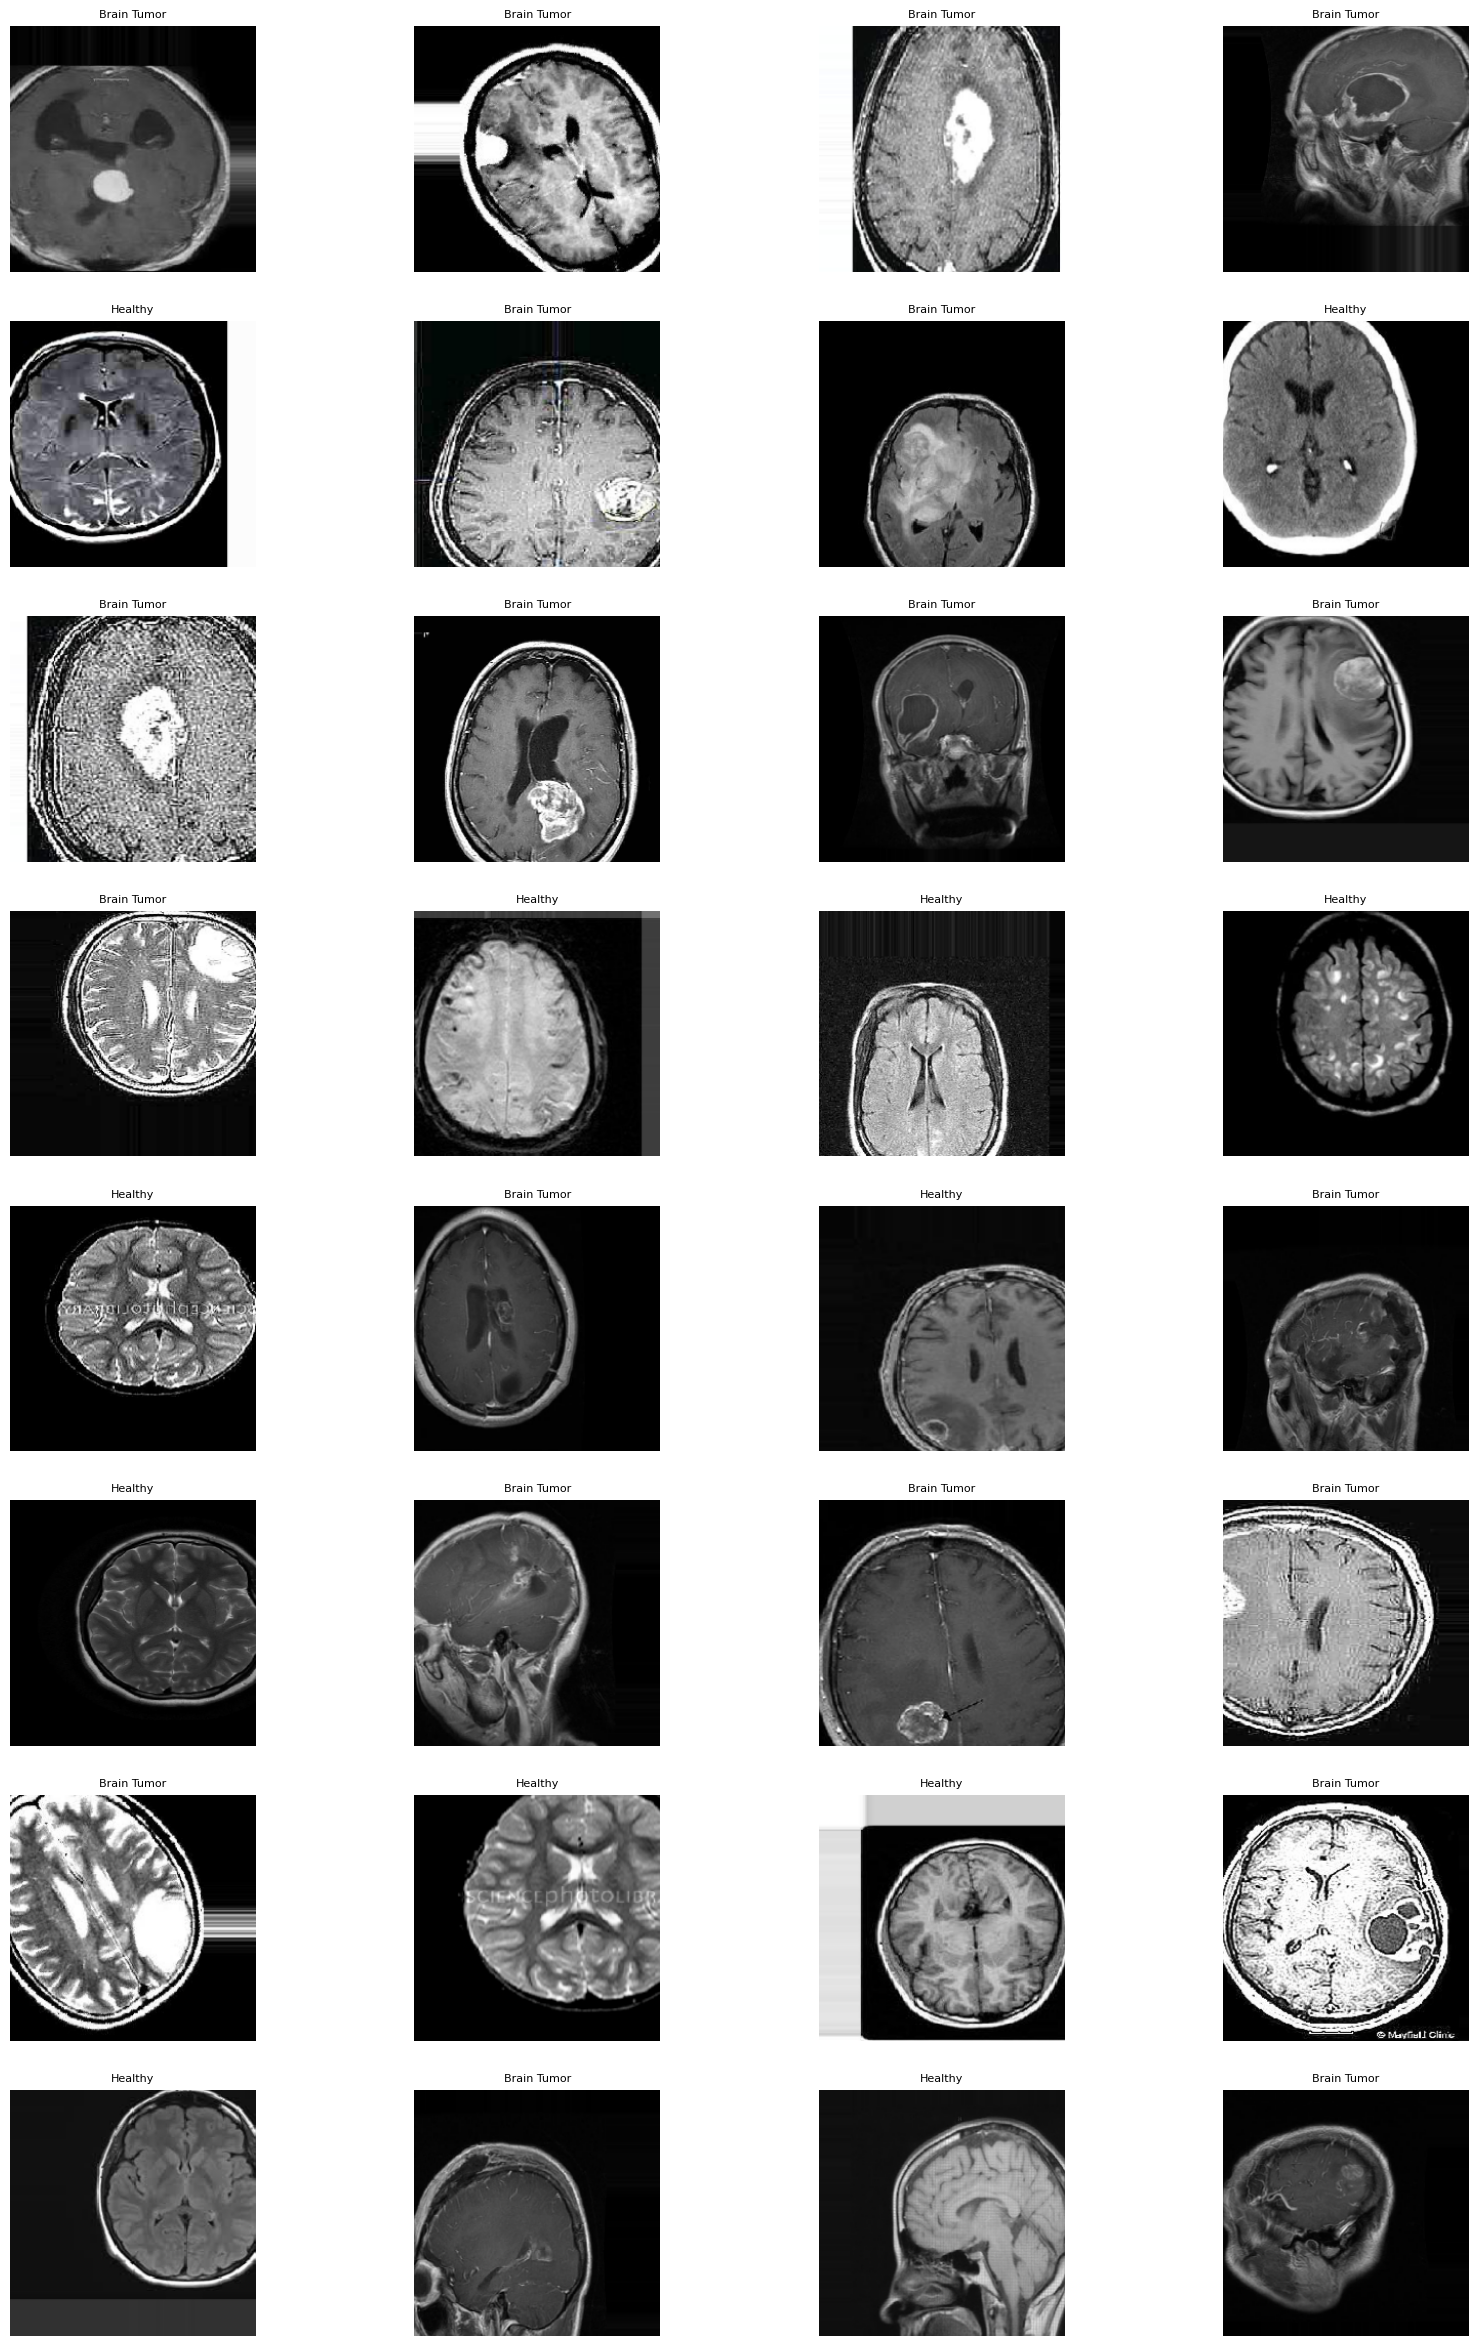

------------Validation Set------------


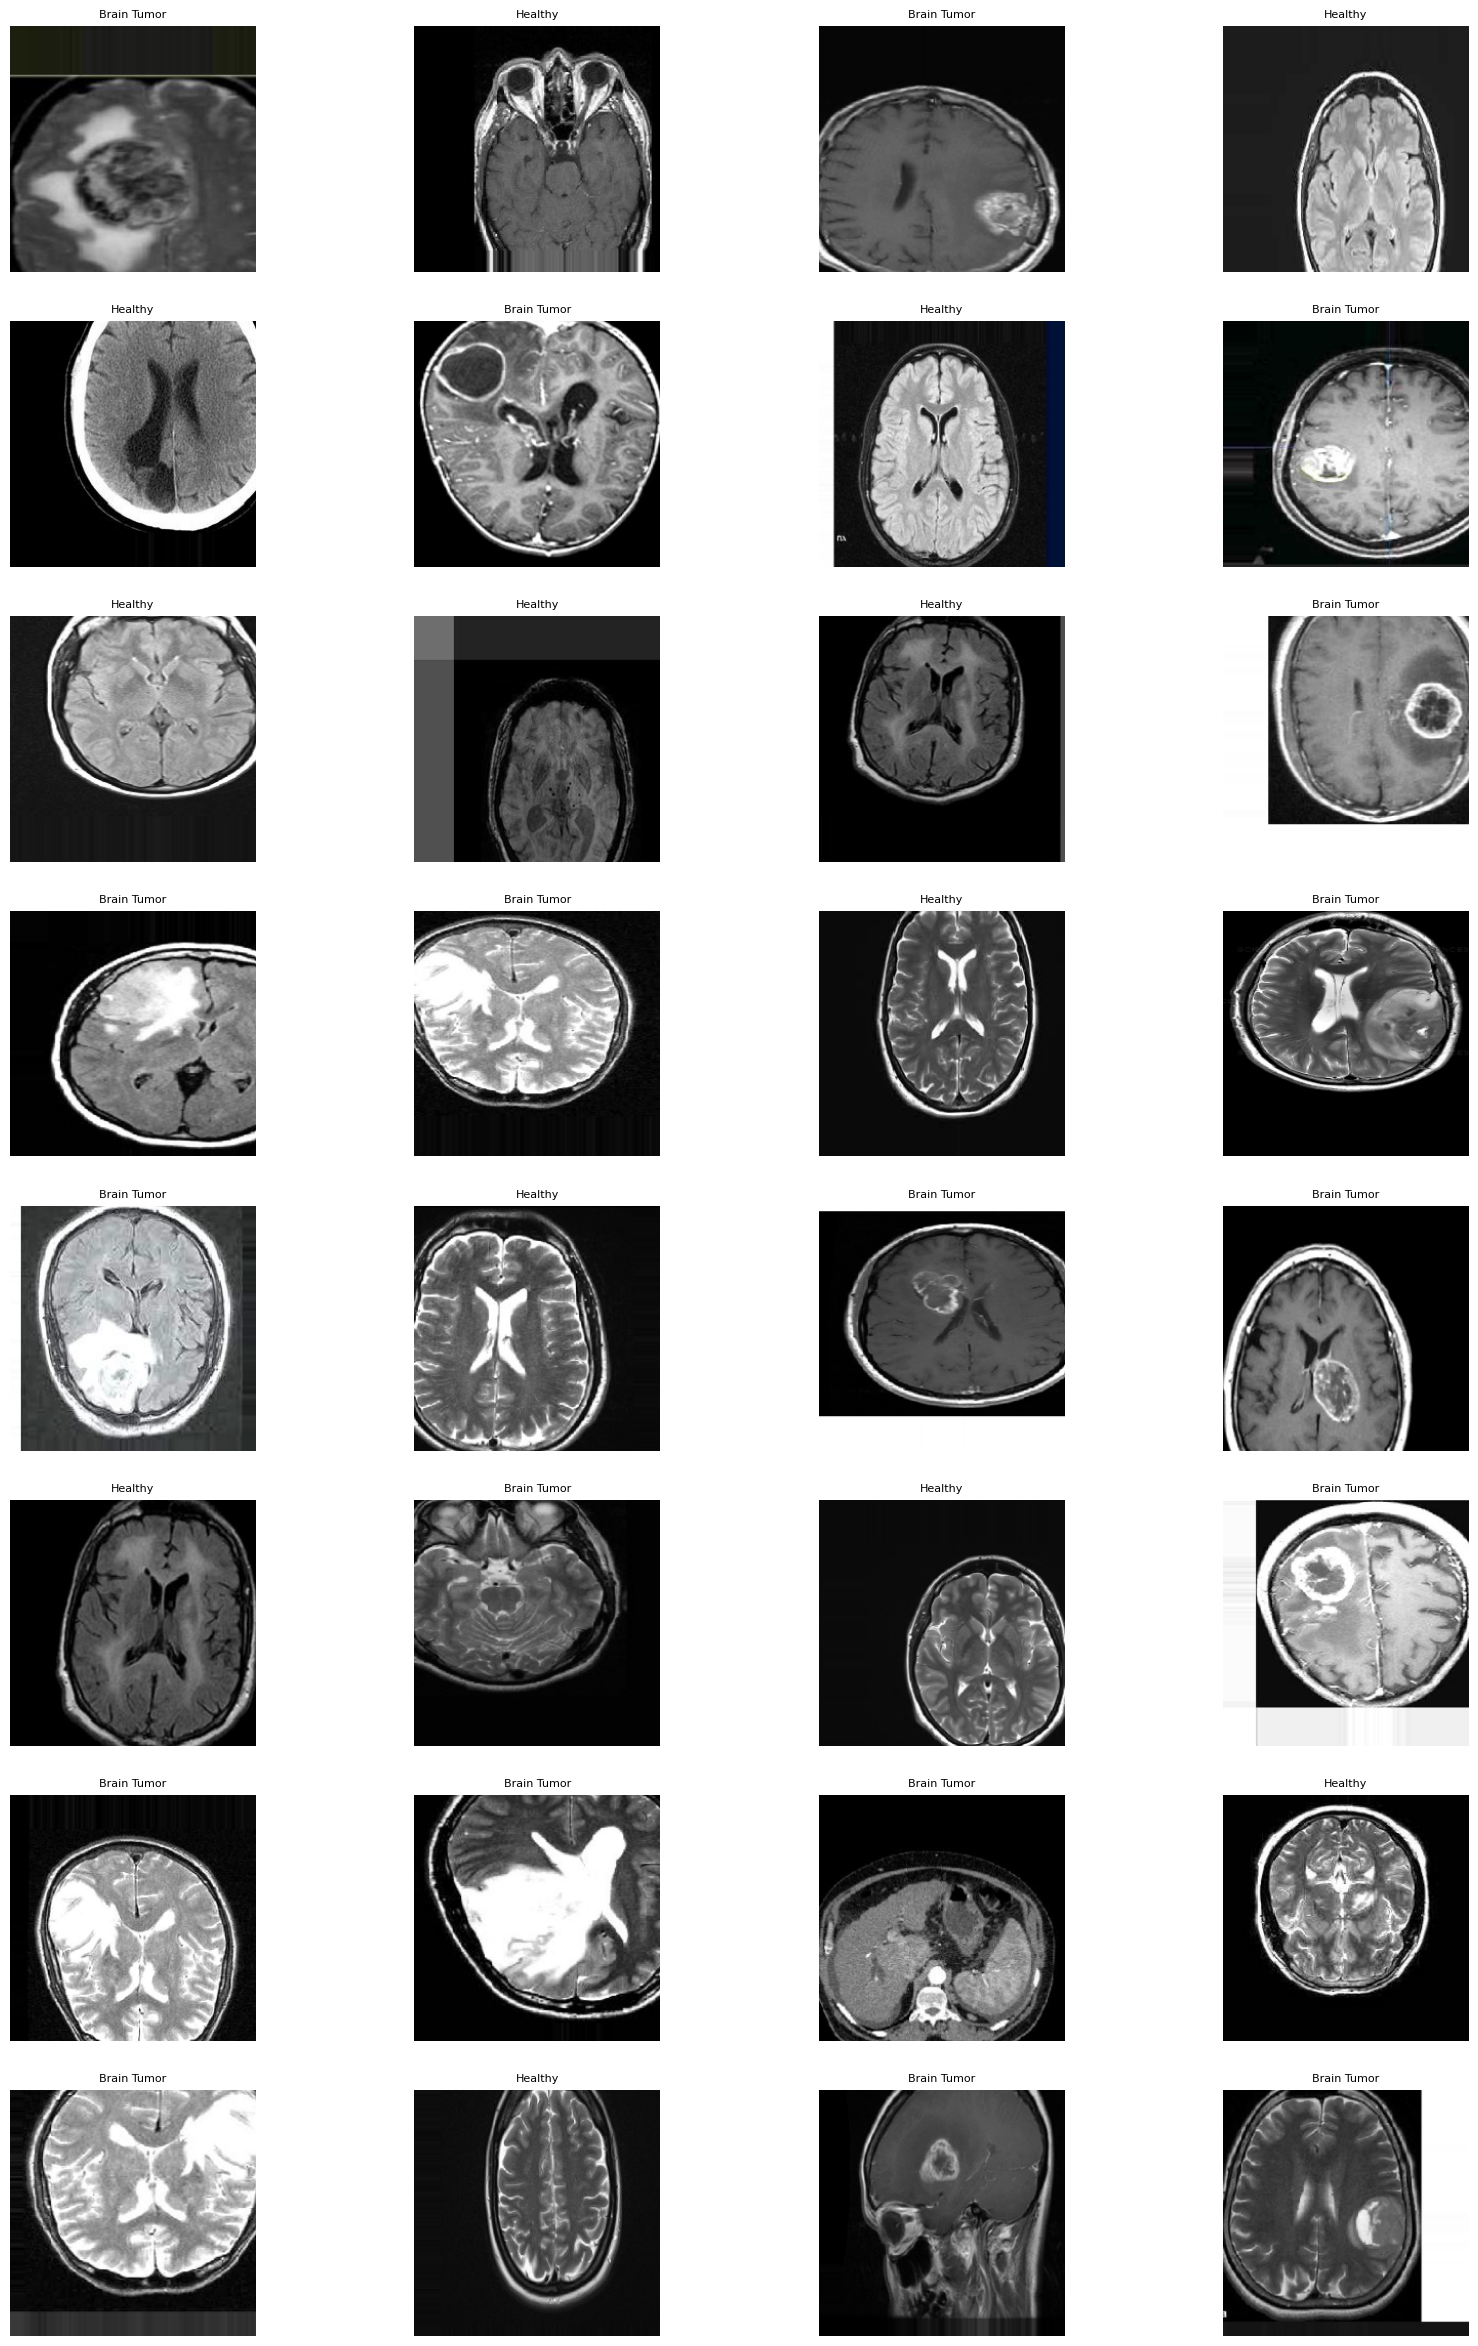

------------Test Set------------


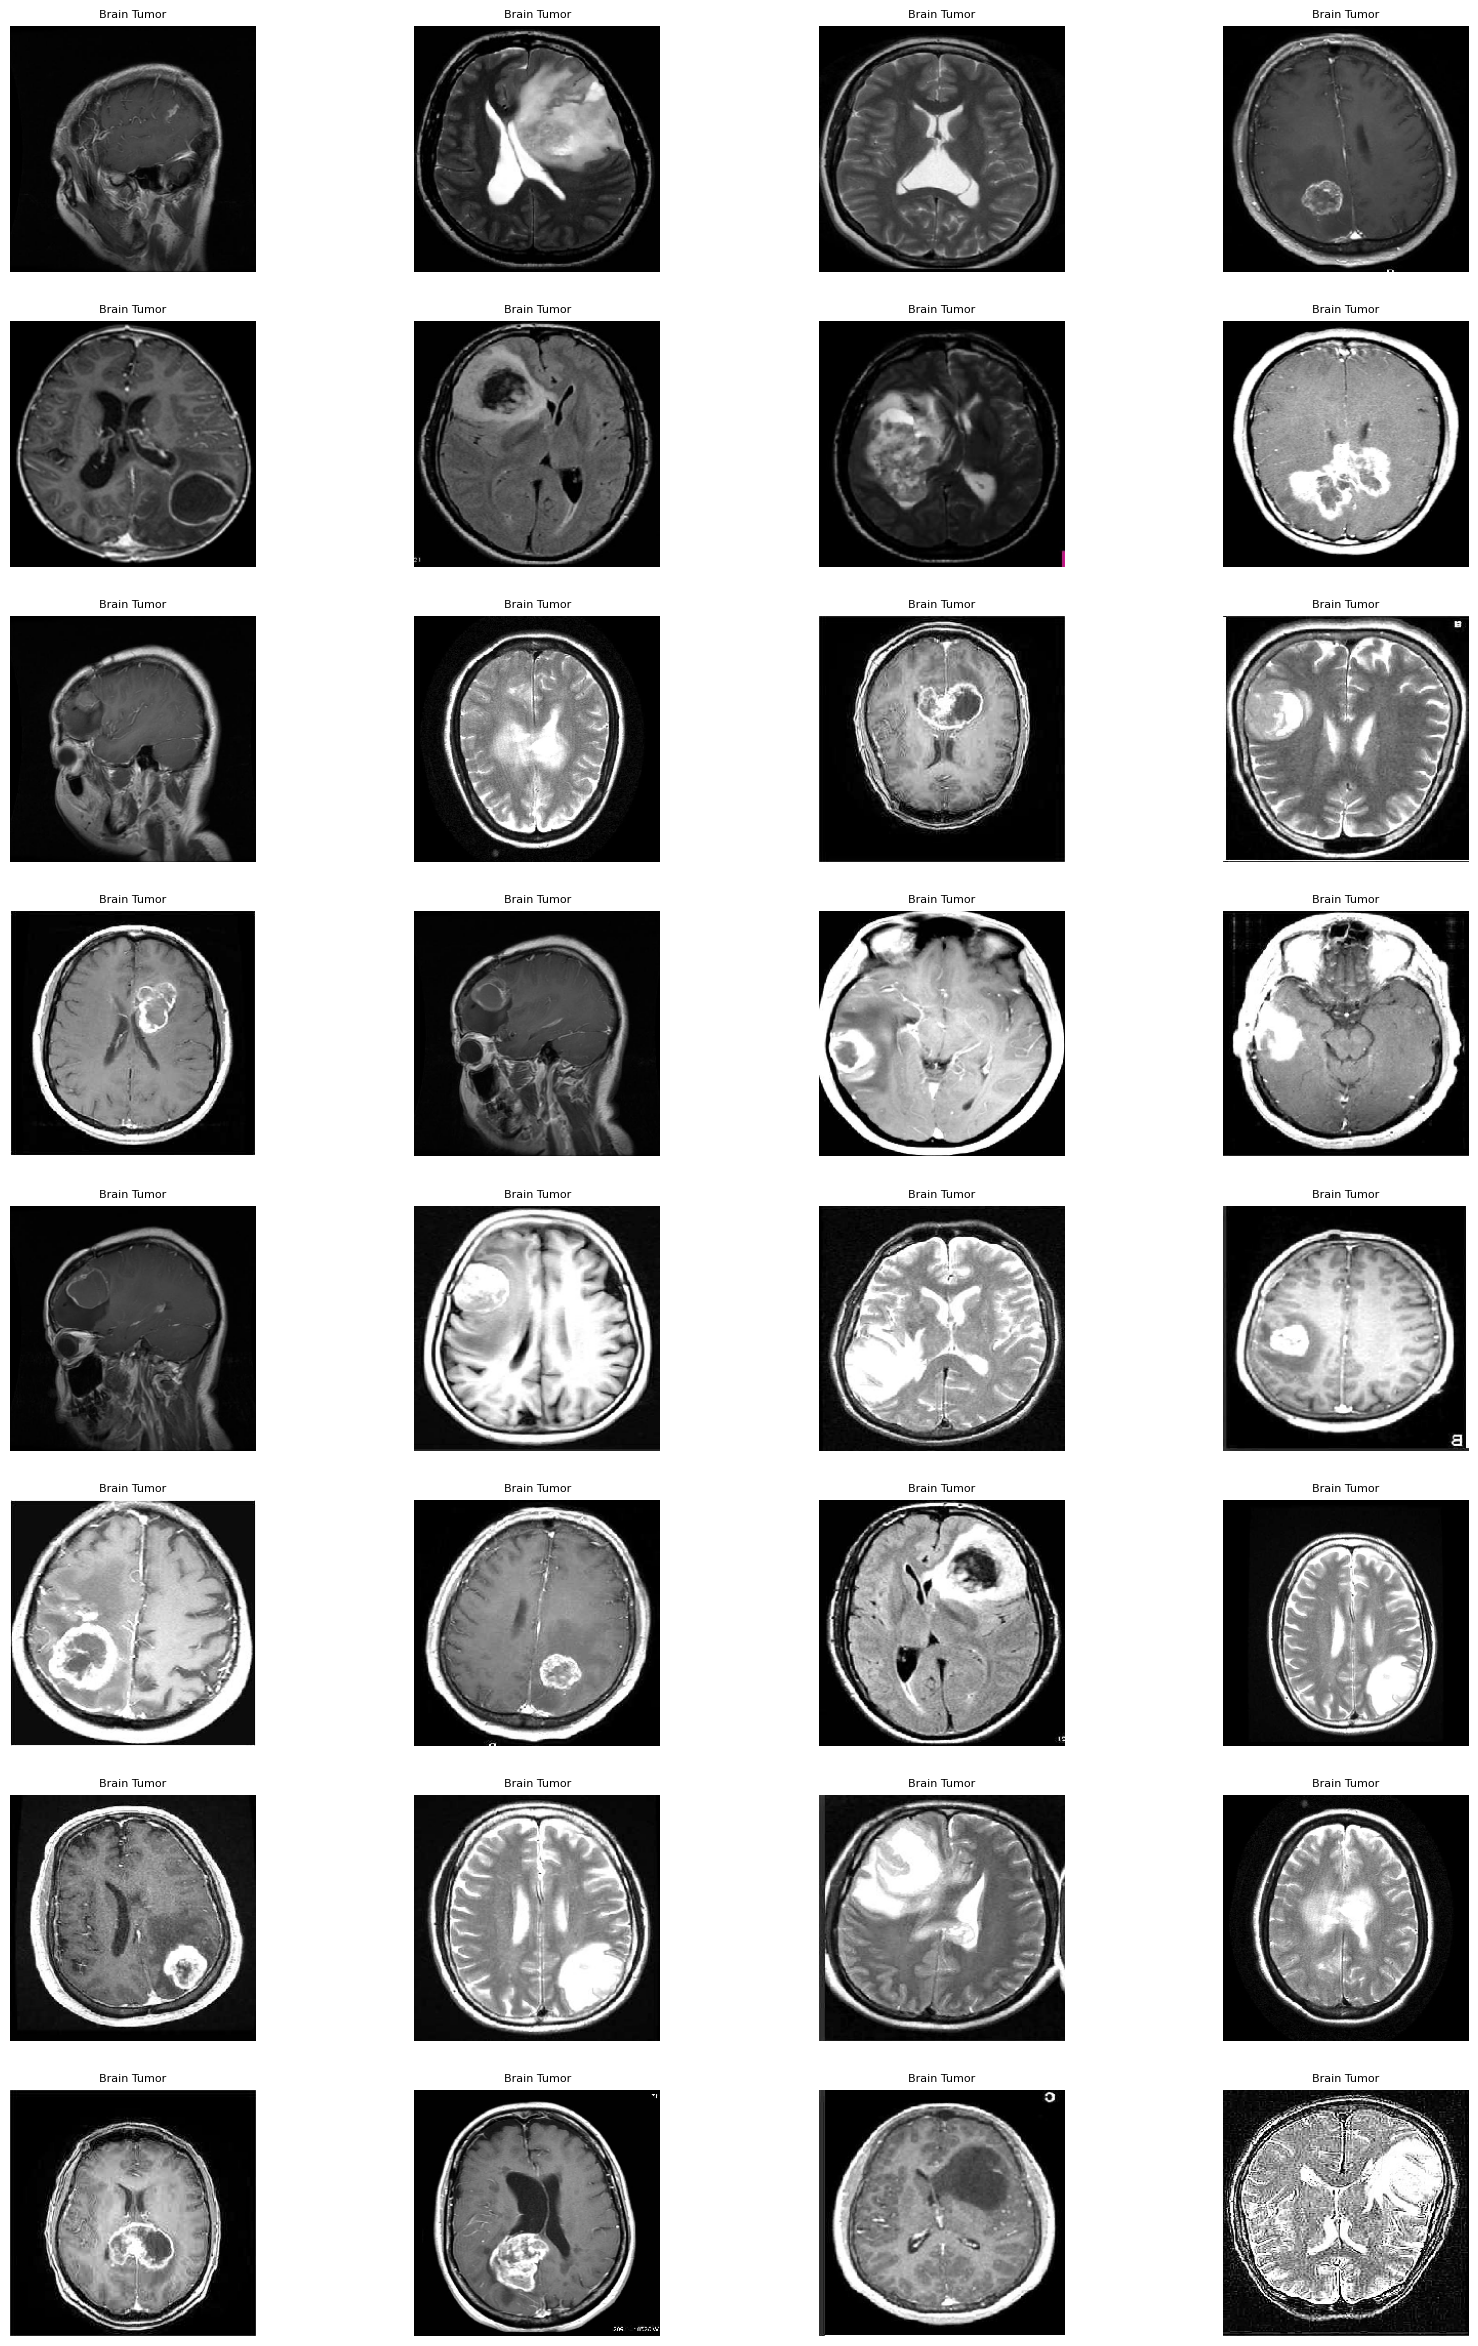

In [11]:
def visualize_image(generator, num_images=100):
    reverse_labels = {v: k for k, v in labels_brain.items()}
    image_batch, label_batch = next(generator)
    
    plt.figure(figsize=(20, 30))
    for n in range(min(num_images, len(image_batch))):
        ax = plt.subplot(8, 4, n + 1)
        
        # rescale to 0-255
        img_rescaled = (image_batch[n] * 255).astype('uint8')
        plt.imshow(img_rescaled)
        
        # Show Labels
        class_index = np.argmax(label_batch[n])
        class_name = reverse_labels[class_index]
        plt.title(class_name, fontsize=8)
        plt.axis("off")
    plt.show()

print("------------Train Set------------")
visualize_image(train_generator, num_images=32)

print("------------Validation Set------------")
visualize_image(val_generator, num_images=32)

print("------------Test Set------------")
visualize_image(test_generator, num_images=32)


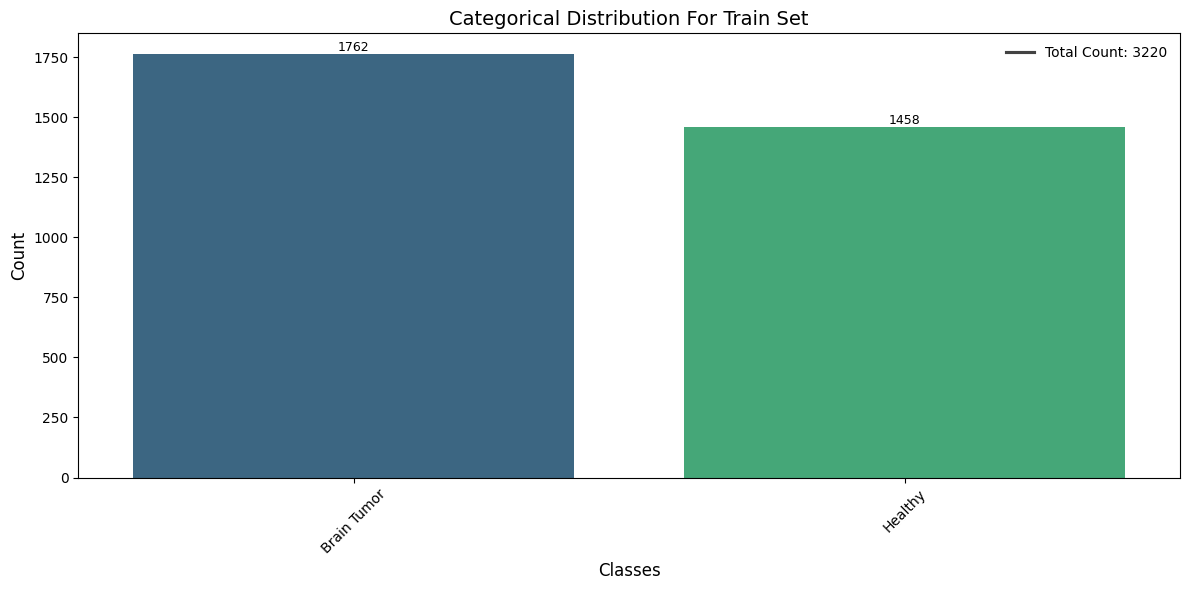

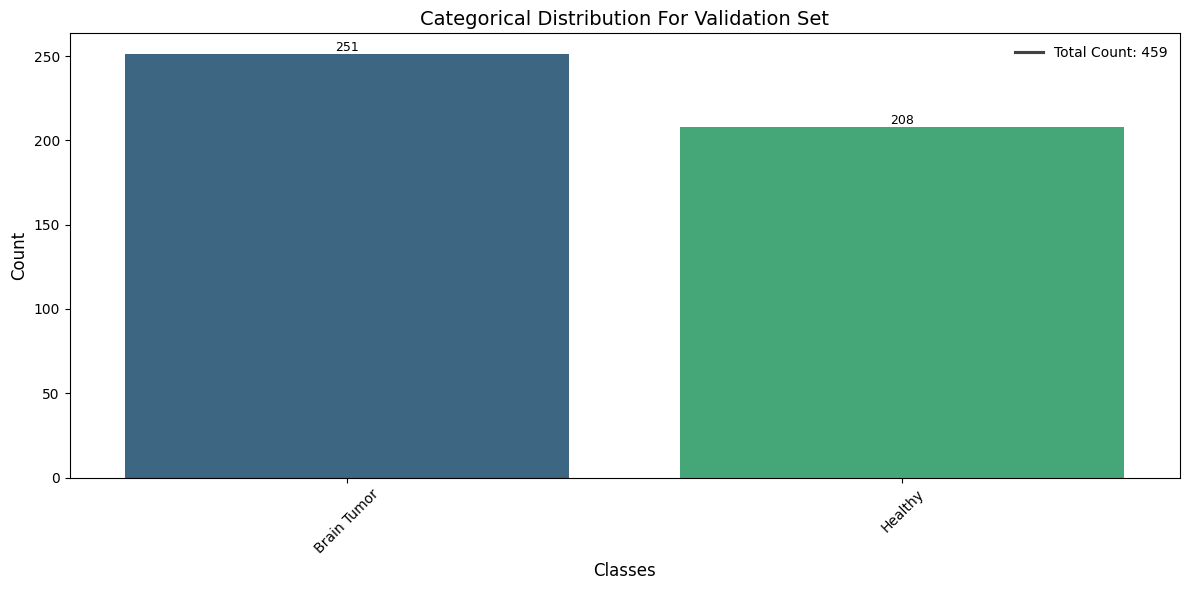

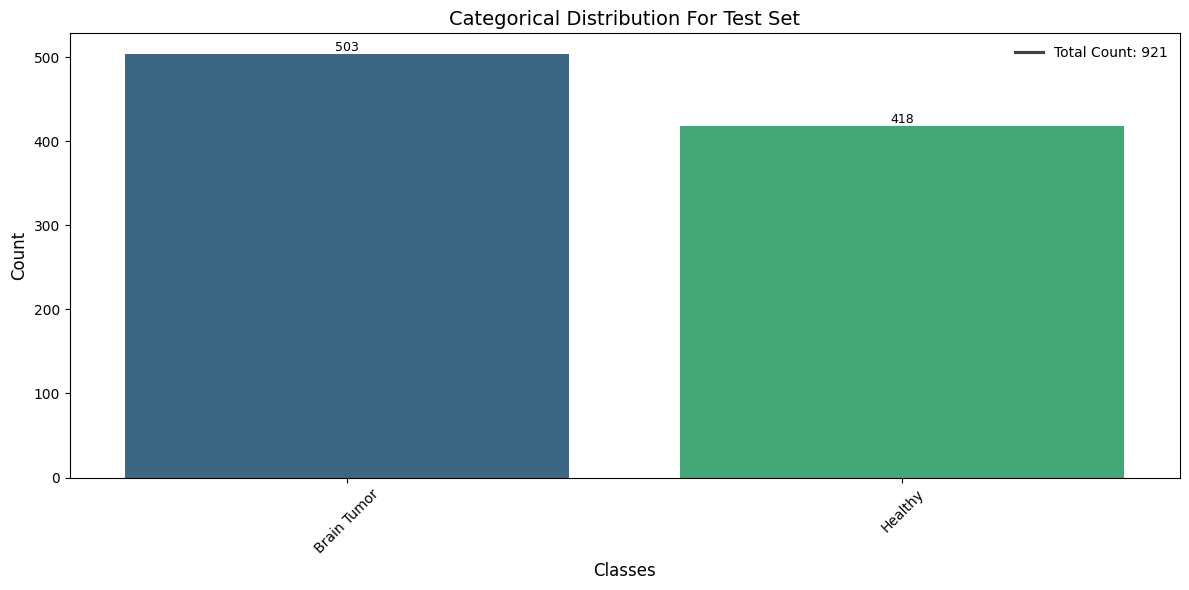

In [12]:
def extract_labels(generator):
    labels = []
    for _ in range(len(generator)):
        _, label_batch = next(generator)
        labels.extend(np.argmax(label_batch, axis=1))
    return labels

def plot_label_distribution(labels, title_name):
    reverse_labels        = {v: k for k, v in labels_brain.items()}
    title                 = "Categorical Distribution For " + title_name
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_names_list      = [reverse_labels[label] for label in unique_labels]

    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=label_names_list, y=counts, palette="viridis")

    # Quantity
    for bar, count in zip(bars.patches, counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{count}',
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.title(title, fontsize=14)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

    # Legend
    total_count = np.sum(counts)
    plt.legend(
        [f"Total Count: {total_count}"],
        loc="upper right",
        frameon=False,
        fontsize=10
    )

    plt.tight_layout()
    plt.show()

# find labels
train_labels      = extract_labels(train_generator)
validation_labels = extract_labels(val_generator)
test_labels       = extract_labels(test_generator)

plot_label_distribution(train_labels, "Train Set")
plot_label_distribution(validation_labels, "Validation Set")
plot_label_distribution(test_labels, "Test Set")


In [13]:
def plot_pie_chart(labels, title_name):
    reverse_labels = {v: k for k, v in labels_brain.items()}
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_names_list = [reverse_labels[label] for label in unique_labels]

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=label_names_list, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(counts)))
    plt.title(f"Pie Chart for {title_name}", fontsize=14)
    plt.show()

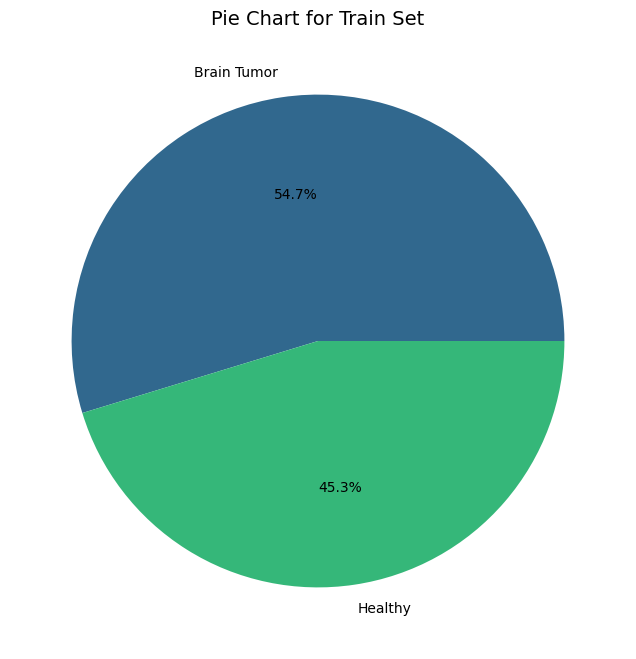

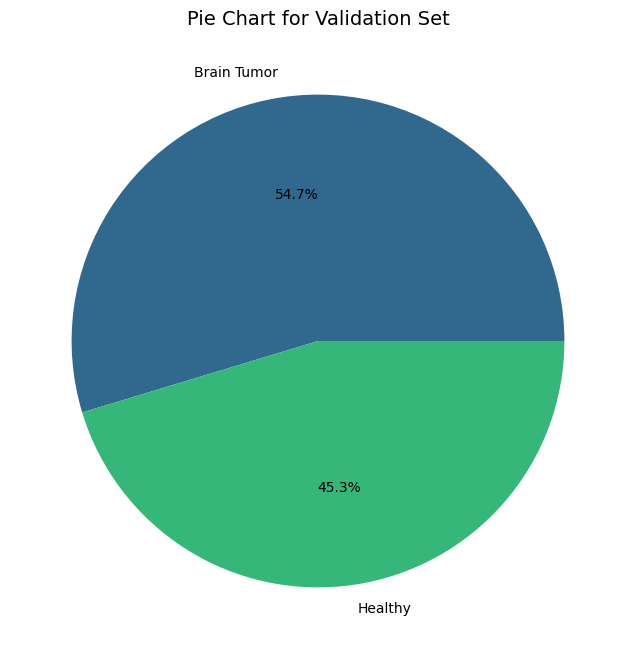

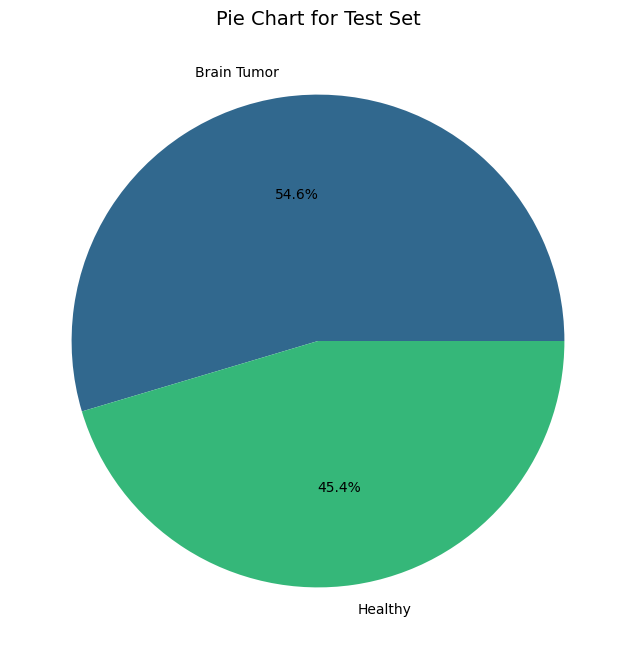

In [14]:
plot_pie_chart(train_labels, "Train Set")
plot_pie_chart(validation_labels, "Validation Set")
plot_pie_chart(test_labels, "Test Set")